In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6
pd.set_option('display.max_rows', None)

In [2]:
data = pd.read_csv('municipality_bus_utilization.csv')  
print('dataset shape: ', data.shape)
data.head()

dataset shape:  (13070, 4)


,timestamp,municipality_id,usage,total_capacity
0,6/4/2017 7:59,9,454,1332
1,6/4/2017 7:59,8,556,2947
2,6/4/2017 7:59,4,1090,3893
3,6/4/2017 7:59,0,204,2813
4,6/4/2017 7:59,7,718,2019


In [3]:
#Unique values for each feature
data.nunique()

timestamp          1306
municipality_id      10
usage              2346
total_capacity       10
dtype: int64

In [4]:
data.isnull().sum()

timestamp          0
municipality_id    0
usage              0
total_capacity     0
dtype: int64

In [5]:
#Now we may also create sub_dataset for each municipality_id:

for i in range(0, 10):
    exec(f"data_{i} = data.copy()")
    exec(f"data_{i}.drop(data_{i}[data_{i}['municipality_id'] != {i}].index, inplace = True)")
    exec(f"data_{i}['timestamp'] = pd.to_datetime(data_{i}['timestamp'], infer_datetime_format = False)")
    exec(f"data_{i} = data_{i}.sort_values(by='timestamp',ascending=True)")
    exec(f"data_{i} = data_{i}.reset_index(drop=True)")
    exec(f"data_{i}['usage'] = data_{i}['usage'].astype(float)")
    exec(f"print('data_{i} shape is:', data_{i}.shape)")

data_0 shape is: (1307, 4)
data_1 shape is: (1307, 4)
data_2 shape is: (1307, 4)
data_3 shape is: (1307, 4)
data_4 shape is: (1307, 4)
data_5 shape is: (1307, 4)
data_6 shape is: (1307, 4)
data_7 shape is: (1307, 4)
data_8 shape is: (1307, 4)
data_9 shape is: (1307, 4)


In [6]:
data_0.head(10)

,timestamp,municipality_id,usage,total_capacity
0,2017-06-04 07:59:00,0,204.0,2813
1,2017-06-04 08:25:00,0,247.0,2813
2,2017-06-04 08:59:00,0,332.0,2813
3,2017-06-04 09:32:00,0,429.0,2813
4,2017-06-04 09:59:00,0,485.0,2813
5,2017-06-04 10:26:00,0,534.0,2813
6,2017-06-04 10:59:00,0,583.0,2813
7,2017-06-04 11:25:00,0,597.0,2813
8,2017-06-04 11:59:00,0,614.0,2813
9,2017-06-04 12:29:00,0,613.0,2813


In [7]:
# data_0['timestamp'].dt.minute.unique().tolist()

In [8]:
# Fixing all hour entries to be exactly at hour:00 and taking the max values between these two entries for each hour:

for i in range(0, 10):
    exec(f"x = len(data_{i})")
    for n in range(x):
        if eval(f"data_{i}")['timestamp'][n].minute > 47:
            eval(f"data_{i}").at[n, 'timestamp'] = eval(f"data_{i}")['timestamp'][n].replace(hour=eval(f"data_{i}")['timestamp'][n].hour + 1, minute = 0, second = 0)
        else:
            eval(f"data_{i}").at[n, 'timestamp'] = eval(f"data_{i}")['timestamp'][n].replace(minute = 0, second = 0)
    exec(f"print('data_{i} shape is:', data_{i}.shape)")

data_0 shape is: (1307, 4)
data_1 shape is: (1307, 4)
data_2 shape is: (1307, 4)
data_3 shape is: (1307, 4)
data_4 shape is: (1307, 4)
data_5 shape is: (1307, 4)
data_6 shape is: (1307, 4)
data_7 shape is: (1307, 4)
data_8 shape is: (1307, 4)
data_9 shape is: (1307, 4)


In [9]:
#Lets look how the individual datasets looks now by taking a sample from data_0:
data_0.head(10)

,timestamp,municipality_id,usage,total_capacity
0,2017-06-04 08:00:00,0,204.0,2813
1,2017-06-04 08:00:00,0,247.0,2813
2,2017-06-04 09:00:00,0,332.0,2813
3,2017-06-04 09:00:00,0,429.0,2813
4,2017-06-04 10:00:00,0,485.0,2813
5,2017-06-04 10:00:00,0,534.0,2813
6,2017-06-04 11:00:00,0,583.0,2813
7,2017-06-04 11:00:00,0,597.0,2813
8,2017-06-04 12:00:00,0,614.0,2813
9,2017-06-04 12:00:00,0,613.0,2813


In [10]:
# data_0['timestamp'].dt.day.unique().tolist()

In [11]:
# Now we aggregate by taking max usage value for each hour as suggested by you:
for i in range(0, 10):
    exec(f"data_{i}_x = pd.DataFrame(columns=['timestamp', 'municipality_id', 'usage', 'total_capacity'])")
    exec(f"data_{i}_x['timestamp'] = pd.to_datetime(data_{i}_x['timestamp'], infer_datetime_format = True)")
    months = eval(f"data_{i}['timestamp'].dt.month.unique().tolist()")
    for month in months:
        days = eval(f"data_{i}[(data_{i}['timestamp'].dt.month == {month})]['timestamp'].dt.day.unique().tolist()")
        for day in days:
            hours = eval(f"data_{i}[(data_{i}['timestamp'].dt.month == {month}) & (data_{i}['timestamp'].dt.day == {day})]['timestamp'].dt.hour.unique().tolist()")
            for hour in hours:
                max_usage = max(eval(f"data_{i}[data_{i}['timestamp'] == '2017-' + str({month}).zfill(2) +'-' + str({day}).zfill(2) + ' ' + str({hour}).zfill(2) +':00:00']")['usage'].tolist())
                df = eval(f"data_{i}[(data_{i}['timestamp'] == '2017-' + str({month}).zfill(2) +'-' + str({day}).zfill(2) + ' ' + str({hour}).zfill(2) +':00:00') & (data_{i}['usage'] == max_usage)]")
                exec(f"data_{i}_x = pd.concat([data_{i}_x, df])")
                exec(f"data_{i}_x = data_{i}_x.reset_index(drop=True)")  
    exec(f"data_{i}_x = data_{i}_x.drop(['municipality_id', 'total_capacity'], axis=1)")
    exec(f"indexedDatatset_{i} = data_{i}_x.set_index(['timestamp'])")

In [12]:
indexedDatatset_0.head(10)

,usage
timestamp,
2017-06-04 08:00:00,247.0
2017-06-04 09:00:00,429.0
2017-06-04 10:00:00,534.0
2017-06-04 11:00:00,597.0
2017-06-04 12:00:00,614.0
2017-06-04 13:00:00,605.0
2017-06-04 14:00:00,585.0
2017-06-04 15:00:00,538.0
2017-06-04 16:00:00,470.0


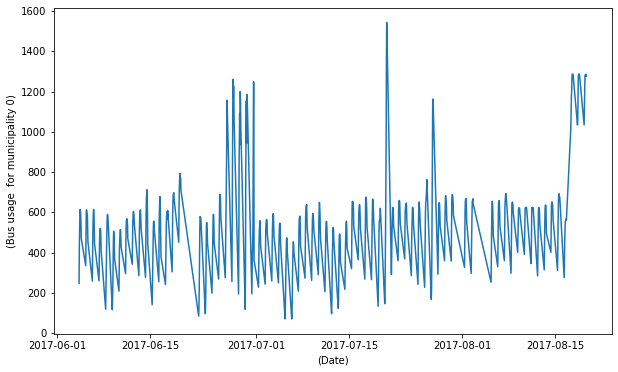

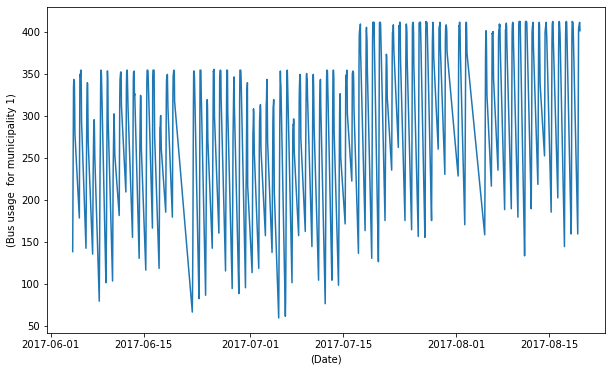

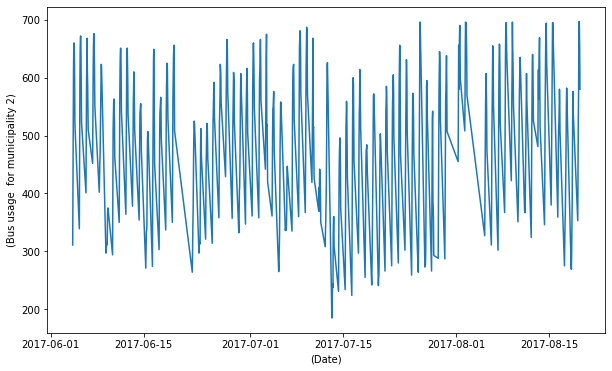

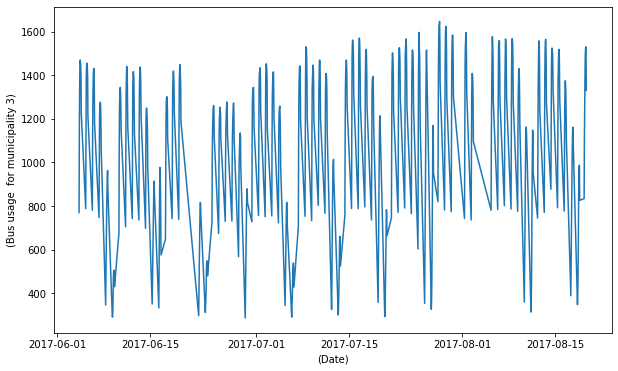

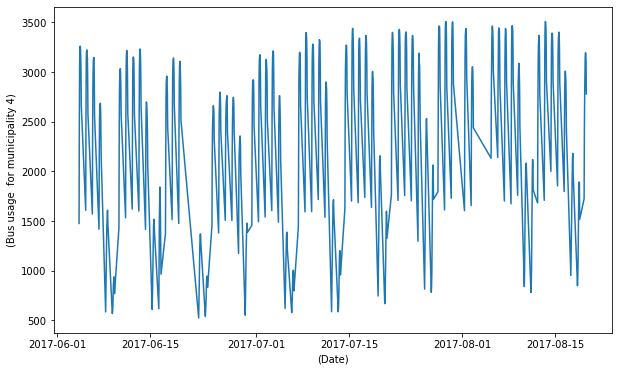

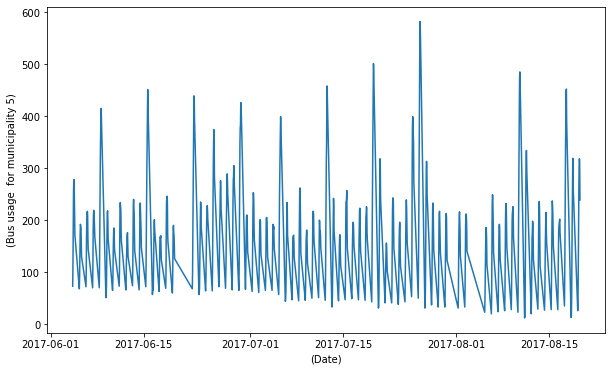

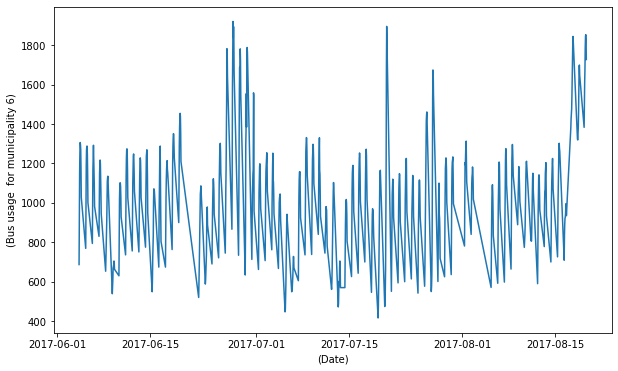

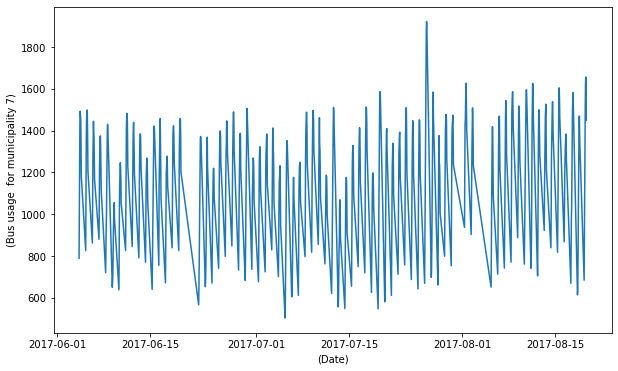

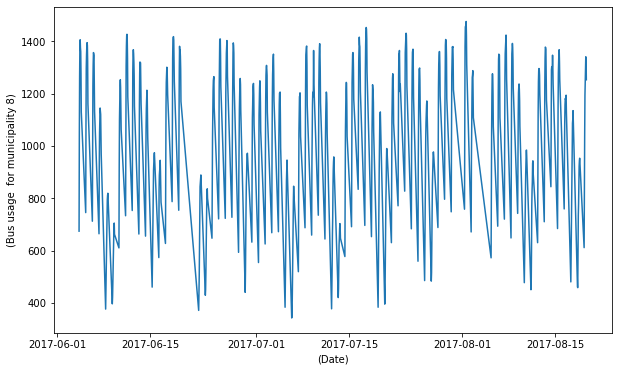

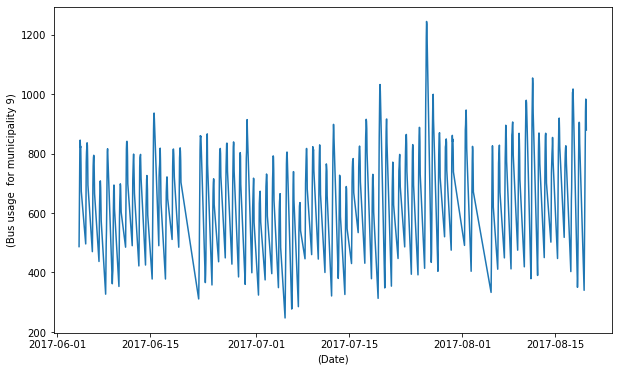

In [13]:
#Plot Bus usage for each municipality against date:

for i in range(0, 10):
    plt.figure()
    plt.xlabel('(Date)')
    exec(f"plt.ylabel('(Bus usage  for municipality ' + str({i}) + ')')")
    exec(f"plt.plot(indexedDatatset_{i})")
    print('')

In [138]:
#Create a function that splits the datasets into two sub_train and two sub_test datasets:

#First train dataset will not include nither of the two last weeks
#First test dataset will include only the first week from the last two weeks
#Second train dataset will also include onle the first week from the two last two weeks
#Second test dataset will include only the last week from the entire dataset


def dataset_splitter(dataset):
    datasetX = dataset.copy()

    ###################################################################################################
    #Detrmine first week length:
    datasettemp = datasetX.reset_index()
    train_data_last_day_time_stamp = datasettemp['timestamp'][datasettemp.index[datasettemp['timestamp'] == '2017-08-05 08:00:00'].tolist()[0] - 1]
    LastTwoWeeks = datasetX.truncate(before=str(train_data_last_day_time_stamp))
    LastTwoWeeksLen = len(pd.DatetimeIndex((LastTwoWeeks.reset_index())['timestamp']).day.unique().tolist())

    FirstWeekLen = int(LastTwoWeeksLen/2)
    ###################################################################################################

    dataset_train_1 = datasetX.truncate(after=str(train_data_last_day_time_stamp))
    dataset_test_1 = datasetX.truncate(before='2017-08-05 08:00:00', after ='2017-08-' + str(5 + FirstWeekLen) + ' 16:00:00')

    dataset_train_2 = datasetX.truncate(after='2017-08-' + str(5 + FirstWeekLen) + ' 16:00:00')
    dataset_test_2 = datasetX.truncate(before='2017-08-' + str(5 + FirstWeekLen + 1) + ' 08:00:00')

    return dataset_train_1, dataset_test_1, dataset_train_2, dataset_test_2

In [145]:
for i in range(0, 10):
    exec(f"dataset_{i}_train_1, dataset_{i}_test_1, dataset_{i}_train_2, dataset_{i}_test_2 = dataset_splitter(indexedDatatset_{i})")

In [14]:
# This function finds the best values for ARIMAX:
###################################################################################################
def p_d_q_values_finder(indexedDatatset, window):
#     indexedDatatset_logScale = np.log(indexedDatatset)
    indexedDatatset_logScale = indexedDatatset
    p_value = 1
    shift = 1
    while p_value > 0.05:
        indexedDatatset_logScale_shiftted = indexedDatatset_logScale - indexedDatatset_logScale.shift(window * shift)
        indexedDatatset_logScale_shiftted = indexedDatatset_logScale_shiftted.dropna()
        results = adfuller(indexedDatatset_logScale_shiftted)
        labels = ['Test statistic', 'p-value', '#Lage Used', 'Number of Observations Used']
        for value, label in zip(results, labels):
            p_value = results[1]
        if p_value > 0.05:
            shift += 1
    d_value = shift
        
    acf_lags = acf(indexedDatatset_logScale_shiftted, nlags = 20, fft=False)
    for i in range(len(acf_lags)):
        if acf_lags[i] < 0.3:
            p_value = i
            break
            
    pacf_lags = pacf(indexedDatatset_logScale_shiftted, nlags = 20, method = 'ols')
    for i in range(len(pacf_lags)):
        if pacf_lags[i] < 0.3:
            q_value = i
            break
            
    return p_value, d_value, q_value
###################################################################################################    

In [270]:
#Finally we create a function to pridict and plot weekly usage values 
# In order to pridict and plot the usage values for each one in the two last weeks and compute MAE:


import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error as mae


#########################################################################################################
def predict_and_plot(i, window, data_x, data_train_1, data_test_1, data_train_2, data_test_2):

    #Train for First week:
    #########################################################################################################
    p, d, q = p_d_q_values_finder(data_train_1, window)
    model = sm.tsa.statespace.SARIMAX(data_train_1['usage'], order= (p, d, q), seasonal_order = (p, d, q, window))
    model.initialize_approximate_diffuse() # this line
    results = model.fit(maxiter=200)
    #########################################################################################################



    #Pridict and plot First week values:
    #########################################################################################################
    predicited_data = pd.DataFrame(results.predict(start = len(data_train_1), end = len(data_train_2) -1, dynamic = True))
    orignal_data = data_test_1
    mae_score_1 = mae(orignal_data['usage'].to_numpy(),predicited_data['predicted_mean'].to_numpy())
    plt.figure()
    plt.plot(predicited_data['predicted_mean'].tolist(), color = 'red')
    plt.plot(orignal_data['usage'].tolist())
    plt.legend(["Pridictied values", "Actual values"], loc ="lower right")
    plt.title('(Pridicted values and actual values for week 1 for municipality ' + str(i) + ' with MAE = ' + str(round(mae_score_1)) + ')', y=-0.15)
    #########################################################################################################


    #Train for First week:
    #########################################################################################################
    p, d, q = p_d_q_values_finder(data_train_2, window)
    model = sm.tsa.statespace.SARIMAX(data_train_2['usage'], order= (p, d, q), seasonal_order = (p, d, q, window))
    model.initialize_approximate_diffuse() # this line
    results = model.fit(maxiter=200)
    #########################################################################################################


    #Pridict and plot second week values:
    #########################################################################################################
    predicited_data = pd.DataFrame(results.predict(start = len(data_train_2), end = len(data_x) -1, dynamic = True))
    orignal_data = data_test_2
    mae_score_2 = mae(orignal_data['usage'].to_numpy(),predicited_data['predicted_mean'].to_numpy())
    plt.figure()
    plt.plot(predicited_data['predicted_mean'].tolist(), color = 'red')
    plt.plot(orignal_data['usage'].tolist())
    plt.legend(["Pridictied values", "Actual values"], loc ="lower right")
    plt.title('(Pridicted values and actual values for week 2 for municipality ' + str(i) + ' with MAE = ' + str(round(mae_score_2)) + ')', y=-0.15)
    #########################################################################################################
    average_mae = (mae_score_1 + mae_score_2)/2
    print('MAE for municipality over two weeks ' + str(i) + ' is: ', average_mae)
    
    return average_mae
#########################################################################################################

C:\Users\ALAA\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ALAA\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ALAA\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\ALAA\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information an

MAE for municipality over two weeks is 0 is:  260.88134134903055


C:\Users\ALAA\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\ALAA\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ALAA\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ALAA\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer

MAE for municipality over two weeks is 1 is:  58.89051116509336


C:\Users\ALAA\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\ALAA\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ALAA\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ALAA\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer

MAE for municipality over two weeks is 2 is:  91.19510970967005


C:\Users\ALAA\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\ALAA\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ALAA\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ALAA\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer

MAE for municipality over two weeks is 3 is:  219.36234141554857


C:\Users\ALAA\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\ALAA\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ALAA\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ALAA\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer

MAE for municipality over two weeks is 4 is:  498.4791579807144


C:\Users\ALAA\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\ALAA\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ALAA\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ALAA\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starti

MAE for municipality over two weeks is 5 is:  77.18797097842648


C:\Users\ALAA\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\ALAA\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ALAA\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ALAA\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer

MAE for municipality over two weeks is 6 is:  233.79348772736404


C:\Users\ALAA\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\ALAA\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ALAA\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ALAA\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starti

MAE for municipality over two weeks is 7 is:  126.15941773355341


C:\Users\ALAA\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\ALAA\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ALAA\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ALAA\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer

MAE for municipality over two weeks is 8 is:  127.74880771843254


C:\Users\ALAA\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\ALAA\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ALAA\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ALAA\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starti

MAE for municipality over two weeks is 9 is:  116.14571106949828


C:\Users\ALAA\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


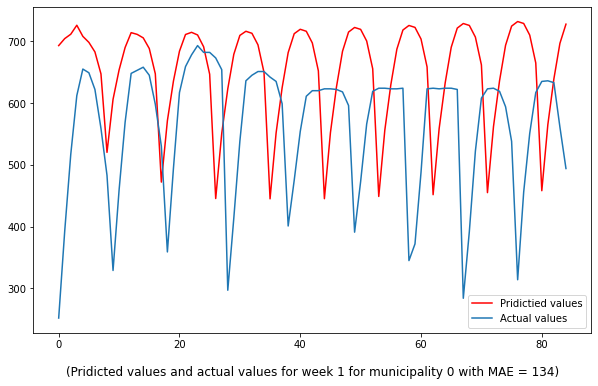

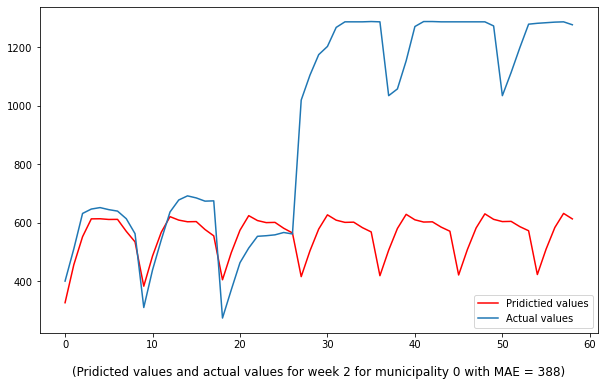

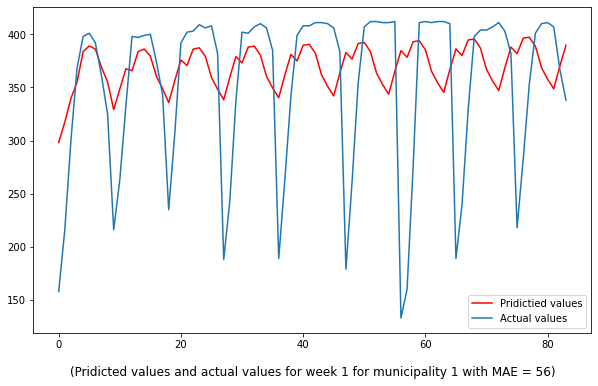

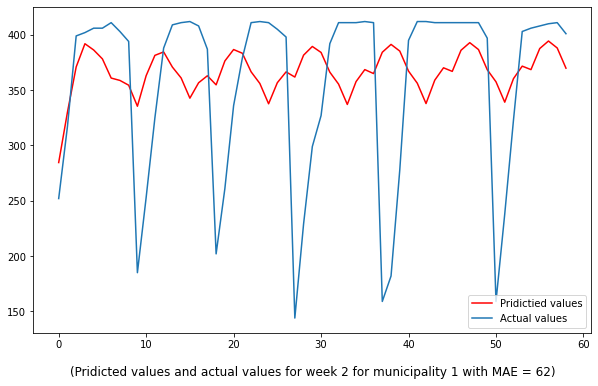

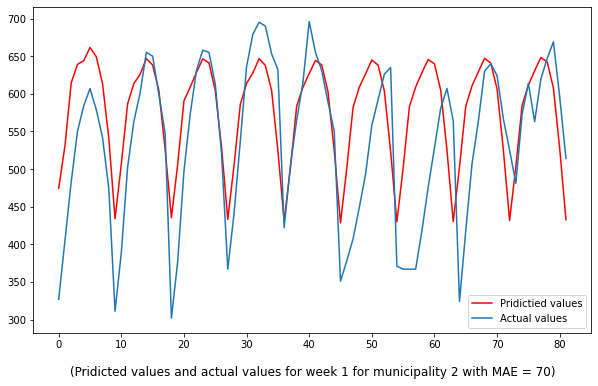

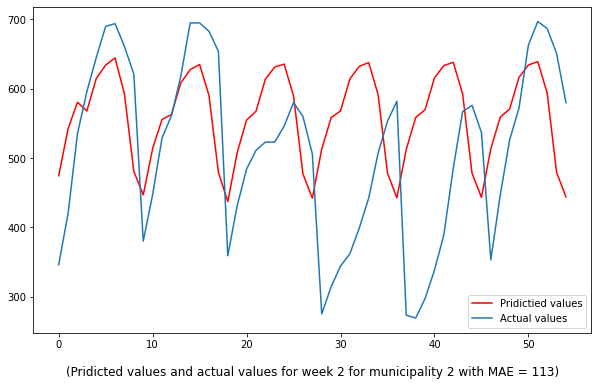

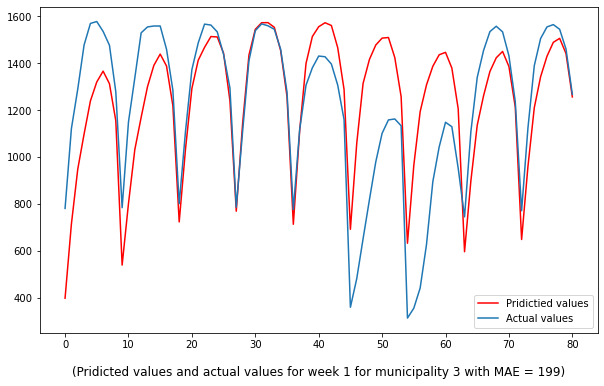

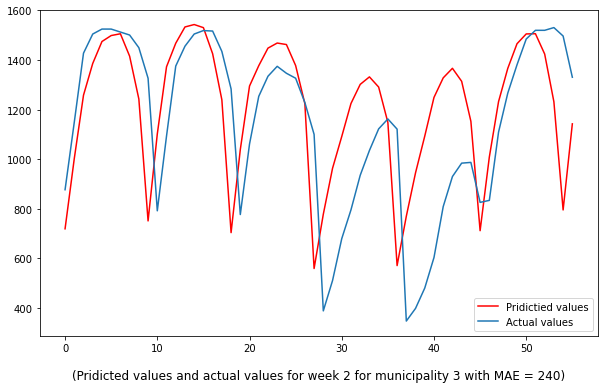

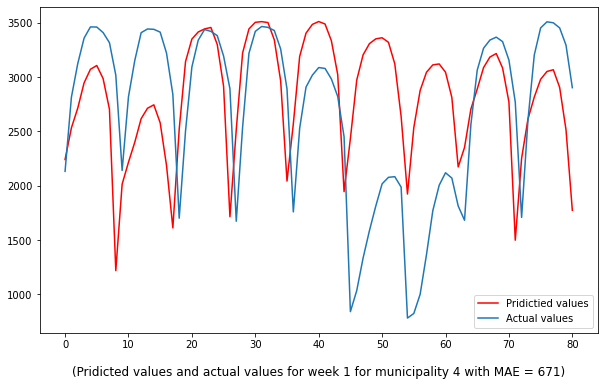

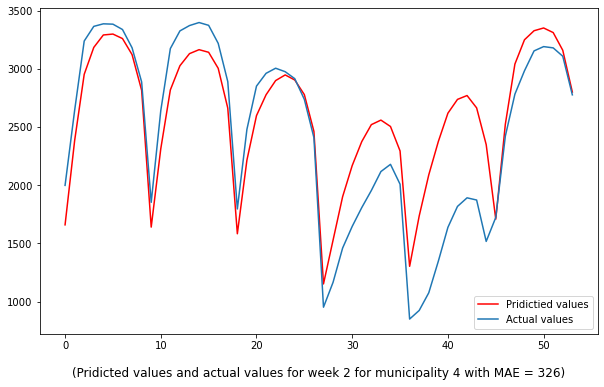

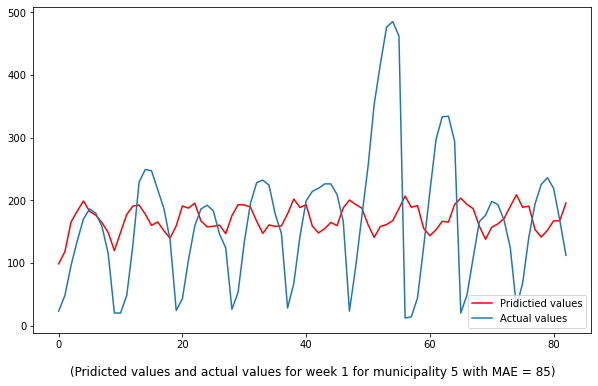

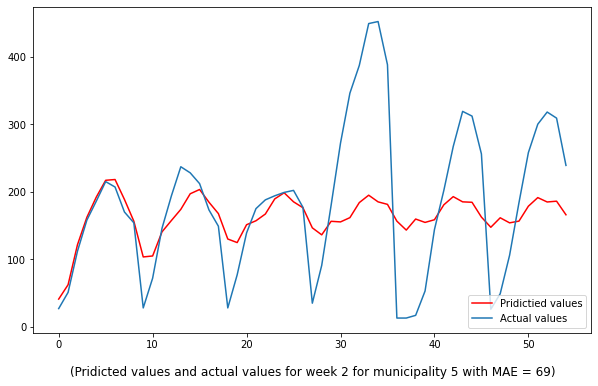

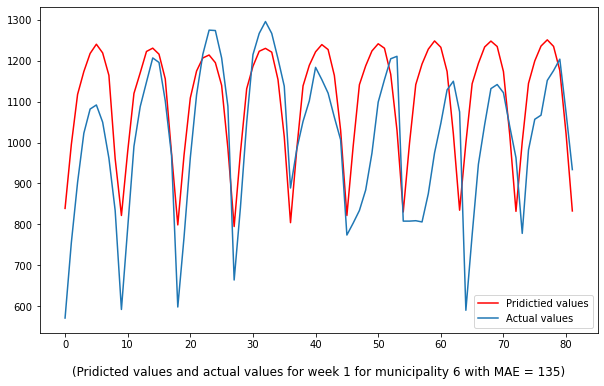

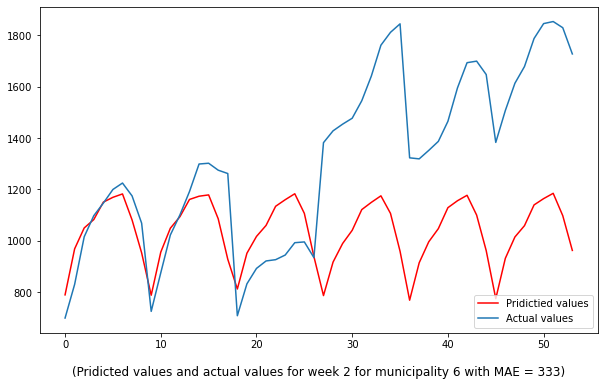

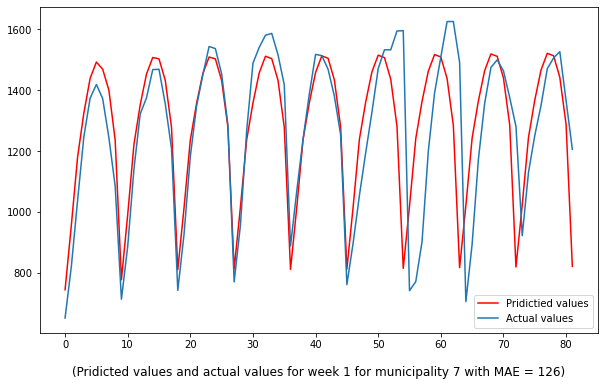

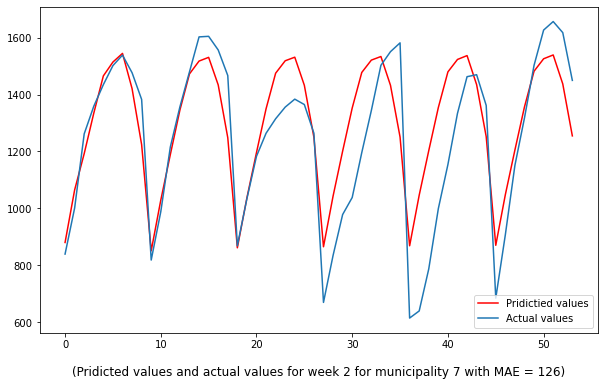

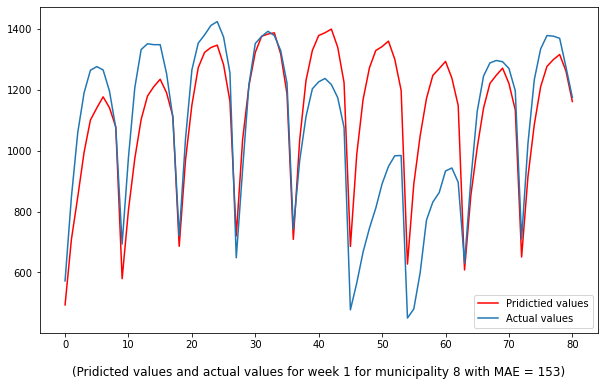

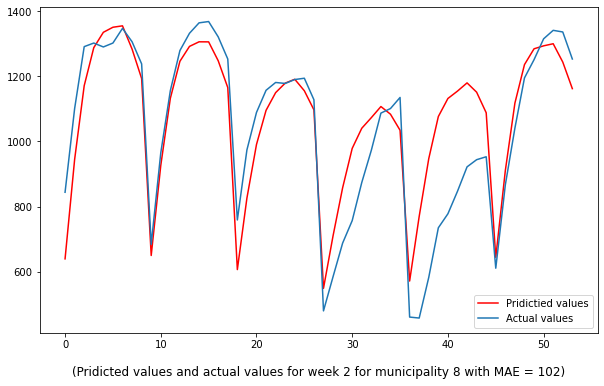

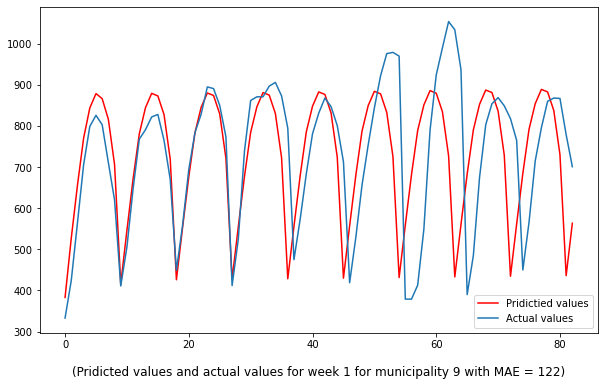

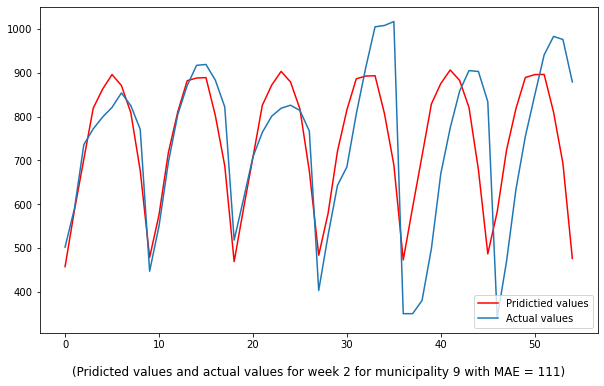

In [273]:
#And finally we pridict and plot usage values for the last two week separately for each municipality 
# and calculate MAE for the results:

for i in range(0, 10):
    window = 9
    exec(f"mae_{i} = predict_and_plot(i, window, indexedDatatset_{i}, dataset_{i}_train_1, dataset_{i}_test_1, dataset_{i}_train_2, dataset_{i}_test_2)")


In [ ]:
#Please check the plots above.

In [274]:
for i in range(0, 10):
    exec(f"print('MAE for municipality ' + str({i}) + ' is: ', mae_{i})")

MAE for municipality 0 is:  260.88134134903055
MAE for municipality 1 is:  58.89051116509336
MAE for municipality 2 is:  91.19510970967005
MAE for municipality 3 is:  219.36234141554857
MAE for municipality 4 is:  498.4791579807144
MAE for municipality 5 is:  77.18797097842648
MAE for municipality 6 is:  233.79348772736404
MAE for municipality 7 is:  126.15941773355341
MAE for municipality 8 is:  127.74880771843254
MAE for municipality 9 is:  116.14571106949828
